In [1]:
# Technical libraries
import cvxpy as cp
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt 

%matplotlib inline

# Set the global variables n (Number of dimensions) and lamb (parameter  lambda of the proximal operator)
n = 30
lamb  = 0.5

# Introduction

the proximal operator of a function $f$ is:

$$prox_f(v) = argmin_x(f(x)+\frac{1}{2\lambda}||x - v||_2^2)$$

# Index
1. [Nonnegativity](#Nonneg)
    1. [Nonnegativity](#Nonneg_function)
    2. [Proximal](#Nonneg_prox)
2. [Regularizers](#Regularizers)
    1. [$L^1$ norm](#l1_function)
        1. [Proximal](#l1_prox)
    2. [$L^2$ norm](#l2_function)
        1. [Proximal](#l1_prox)
3. [$prox_{\Re + \delta_{\rm_+}}(x)$](#Reg+nonneg)
    1. [$L^1$ norm](#l1+nonneg)
    2. [$L^2$ norm](#l2+nonneg)
4. [$prox_{\Re}(prox_{\delta_{\rm_+}}(x))$](#Prox_reg(proxn_onneg))
    1. [$L^1$ norm](#l1(nonneg))
    2. [$L^2$ norm](#l2(nonneg))
4. [$\mathrm{prox}_{\delta_{\rm_+}}(prox_{\Re}(x))$](#Prox_nonneg(prox_reg))
    1. [$L^1$ norm](#nonneg(l1))
    2. [$L^2$ norm](#nonneg(l2))
    


## <a name = 'Nonneg'></a>1. Nonnegativity Function.

### <a name = 'Nonneg_function'></a>1.A The function.

The nonnegativity function $\delta$ is defined as:

$$\delta_{\Re_+^N} =
\begin{cases}
        0 if x \in \Re_+^N \\
        +\inf if x\notin \Re_+^N
     \end{cases}$$

### <a name = 'Nonneg_proximal'></a>1.B The Proximal.

Given the definition of the proximal operator, it is immediate to see that to solve the proximal operator, we have as constraint $x\in \Re_+^N$. As such, the first term vanishes (since $x\in \Re_+^N$, by definition $f(x) = 0$). As such, we arrive to:

$$prox_f(\Re_+^N(v)) = \arg \min_{x\in \Re_+^N}\left(\frac{1}{2}||x - v||_2^2\right)$$

Given that $v \in \Re^N$, then the $x\in \Re_+^N$ that minimizes the prox operator is simply the $x$ closest to $v$, but yet inside the domain imposed by the indicator function (indicator of nonnegativity). It is useless to include the parameter $\lambda$ in this proximal, as the minimization of squares is the only term present. 

Run the next cell to look at the proximal. $v$ is chosen from a normal distribution ($\mu = 0, \sigma = 1$). If `n == 2`, you can run the cell several times and you will quickly see how the proximal operator of the non negativity constraint is simply the projection of $v$ into the $I^{st}$ quadrant (the nonnegative quadrant).

Value of v: [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]

The optimal value is 5.489493887070534
The objective value is: 5.489493943657182
The optimal value of x: [1.76405223e+00 4.00157160e-01 9.78737842e-01 2.24089310e+00
 1.86755788e+00 1.78662339e-09 9.50088276e-01 8.27795999e-09
 1.10347028e-08 4.10598464e-01 1.44041316e-01 1.45427338e+00
 7.61037602e-01 1.21672442e-01 4.43863213e-01 3.33674124e-01
 1.49407894e+00 6.99750038e-09 3.13067408e-01 2.12387971e-09
 2.51825950e-10 6.53618503e-01 8.64436062e-01 2.51471883e-09
 2.26975453e+00 9.88638566e-10 4.57557061e-02 7.33608265e-09
 1.53277909e+00 1.46935864e+00]
The norm of the residual is  3.3134555810081965


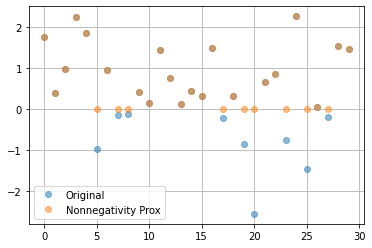

In [2]:
np.random.seed(0)
# Define test vector v
v = np.random.normal(size = (n))
print(f'Value of v: {v}')
# Define cvx variable of the same size as v, constrained to the nonnegative domain
x_nonneg = cp.Variable(n, nonneg = True) 
# Define de the cost function
cost = cp.norm(x_nonneg - v, 2)**2/2
prox_nonneg_prob = cp.Problem(cp.Minimize(cost))
prox_nonneg_prob.solve()

print("\nThe optimal value is", prox_nonneg_prob.value)
print(f"The objective value is: {cp.norm(x_nonneg - v, 2).value**2/2}")
print(f'The optimal value of x: {x_nonneg.value}')
print("The norm of the residual is ", cp.norm(x_nonneg - v, p=2).value)

plt.figure()
if n == 2:
    x = x_nonneg.value
    V = np.array([x, v])
    origin = np.array([[0, 0],[0, 0]]) # origin point

    plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'])
    plt.grid()
else:
    plt.plot(v, 'o', alpha = 0.5, label = 'Original')
    plt.plot(x_nonneg.value, 'o', alpha = 0.5, label = 'Nonnegativity Prox')
    plt.grid()
    plt.legend()

## 2. <a name = 'Regularizer'></a>Regularizer

The concept of regularizer in image reconstruction refers to the previous knowledge that we have on an image. Common regularizers include [Total Variation (TV)](https://en.wikipedia.org/wiki/Total_variation) and norms. In general, regularizers take care of enforcing sparsity, a well known property of natural images. 

### 2.1 <a name = 'L1-Norm'></a> $L^1$ Norm

The $L^1$ norm, from the family of the $L^p$ norms where $p = 1$, is defined for a vector $x$ as:
$$||x||_p = (\sum_{i = 1}^n x^p)^\frac{1}{p} $$

It follows that the $L^1$ norm of a vector is simply the sum of its components. It is a common image regularizer because it enforces sparsity, a well known property of natural images.  

### 2.1.1 <a name = 'L1-Norm_prox'></a>Prox of $L^1$ Norm

Following the definition of the Proximal operator:

$$prox_{L^1}(v) = argmin_x(||x||_1 + \frac{1}{2\lambda}||x - v||_2^2))$$

An intuitive interpretation is that the solution $x$ will be one where each element $x_i$ of $x$ is pulled towards $0$ in order to minimize  the $L^1$ norm (clearly without crossing $0$), but still remaining close to $v$ (to reduce the squared term). How much is it pulled depends on the parameter $\lambda$.

Run the next cell to show this effect.

Value of v: [ 0.15494743  0.37816252 -0.88778575 -1.98079647 -0.34791215  0.15634897
  1.23029068  1.20237985 -0.38732682 -0.30230275 -1.04855297 -1.42001794
 -1.70627019  1.9507754  -0.50965218 -0.4380743  -1.25279536  0.77749036
 -1.61389785 -0.21274028 -0.89546656  0.3869025  -0.51080514 -1.18063218
 -0.02818223  0.42833187  0.06651722  0.3024719  -0.63432209 -0.36274117]

The optimal value is 16.154461867476968
The objective value is: 16.154461867476968
The optimal value of x: [ 1.93652256e-31 -3.46912986e-23 -3.87785748e-01 -1.48079647e+00
 -5.55093019e-23  4.73777064e-23  7.30290681e-01  7.02379849e-01
  1.11003705e-22 -1.62646770e-23 -5.48552965e-01 -9.20017937e-01
 -1.20627019e+00  1.45077540e+00 -9.65218175e-03  5.55018799e-23
 -7.52795360e-01  2.77490356e-01 -1.11389785e+00  1.54376381e-28
 -3.95466561e-01 -4.38012040e-23 -1.08051376e-02 -6.80632184e-01
 -5.05961707e-23 -3.68637461e-23 -4.56904609e-23  3.77963752e-31
 -1.34322094e-01  5.55087989e-23]


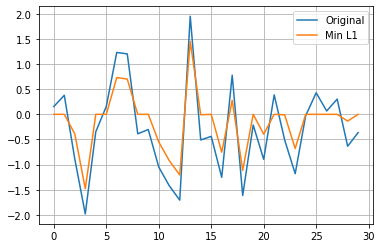

In [3]:
# Set v
v = np.random.normal(size = n)

print(f'Value of v: {v}')
x_l1 = cp.Variable(n) 
# Define de the cost function
obj = cp.norm(x_l1, 1) + cp.sum_squares(x_l1 - v)/(2*lamb)

prox_l1_prob = cp.Problem(cp.Minimize(obj))
prox_l1_prob.solve()

print("\nThe optimal value is", prox_l1_prob.value)
print(f"The objective value is: {cp.norm(x_l1, 1).value + cp.sum_squares(x_l1 - v).value/(2*lamb)}")
print(f'The optimal value of x: {x_l1.value}')

plt.figure()
plt.plot(v, label = 'Original')
plt.plot(x_l1.value, label = 'Min L1')
plt.grid()
plt.legend()

### 2.2 <a name = 'L2-Norm'></a> $L^2$ Norm

The $L^2$ norm, from the family of the $L^p$ norms where $p = 2$, is defined for a vector $x$ as:
$$||x||_p = (\sum_{i = 1}^n x^p)^\frac{1}{p} $$

### 2.2.1 <a name = 'L2-Norm_prox'></a>Prox of $L^2$ Norm

Following the definition of the Proximal operator:

$$prox_{L^2}(v) = argmin_x(||x||_2 + \frac{1}{2\lambda}||x - v||_2^2))$$

An intuitive interpretation is that the solution $x$ will be one where each element $x_i$ of $x$ is pulled towards $0$ in order to minimize  the $L^1$ norm (clearly without crossing $0$), but still remaining close to $v$ (to reduce the squared term). How much is it pulled depends on the parameter $\lambda$

Run the next cell to show this effect

5.248277788337099
Value of v: [-0.67246045 -0.35955316 -0.81314628 -1.7262826   0.17742614 -0.40178094
 -1.63019835  0.46278226 -0.90729836  0.0519454   0.72909056  0.12898291
  1.13940068 -1.23482582  0.40234164 -0.68481009 -0.87079715 -0.57884966
 -0.31155253  0.05616534 -1.16514984  0.90082649  0.46566244 -1.53624369
  1.48825219  1.89588918  1.17877957 -0.17992484 -1.07075262  1.05445173]

The optimal value is 4.748277771117941
The objective value is: 20.150105073461006
The optimal value of x: [-0.54432815 -0.291043   -0.65820736 -1.3973524   0.14361892 -0.32522459
 -1.31957628  0.37460257 -0.73441947  0.04204759  0.59016783  0.10440618
  0.92229643 -0.99953902  0.32567846 -0.55432467 -0.70487329 -0.4685542
 -0.25218853  0.04546346 -0.94313928  0.72918076  0.37693396 -1.24352398
  1.2046769   1.53464172  0.95417197 -0.14564151 -0.86672874  0.8535339 ]


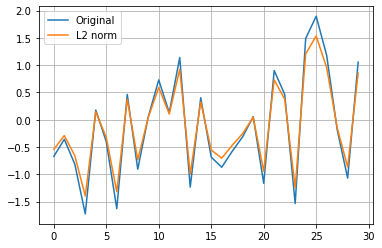

In [16]:
v = np.random.normal(size = n)

print(cp.norm(v, 2).value)
lamb = 1
print(f'Value of v: {v}')
x_l2 = cp.Variable(n) 
# Define de the cost function
obj = cp.norm(x_l2, 2) + cp.sum_squares(x_l2 - v)/(2*lamb)

prox_l2_prob = cp.Problem(cp.Minimize(obj))
prox_l2_prob.solve()

print("\nThe optimal value is", prox_l2_prob.value)
print(f"The objective value is: {cp.norm(x_l2, 1).value + cp.sum_squares(x_l2 - v).value/(2*lamb)}")
print(f'The optimal value of x: {x_l2.value}')
plt.figure()
plt.plot(v, label = 'Original')
plt.plot(x_l2.value, label = 'L2 norm')
plt.grid()
plt.legend()

## <a anchor = 'Reg+nonneg'></a>3. Regularizer + Nonneg
[Back to Index](#Index)

In this section we will actually start with the project, and calculate:

$$prox_{f(x)}(v)$$, 

where 
$$f(x) = \Re + \delta_{\rm_+^N}$$

### <a name = 'l1+nonneg'></a> 3.1 $L^1$ + Nonneg
[Back to Index](#Index)

In this section we will compute the proximal operator of our regularizer and the nonnegativity constraint combined:
$$prox_f(x)$$
where   
$$f(x) = ||x||_1 +  \delta_{\Re_+^N}$$

Following the definition from [section 1.B](#Proximal), and the derivation of the proximal from the nonnegativity constraint, it follows that:

$$prox_{f}(v) = argmin_{x\in \Re_+^N}(||x||_1 + \frac{1}{2\lambda}||x - v||_2^2))$$

In this term we could add the function $\delta_{\Re_+^N}$, but since we have already defined $x\in \Re_+^N$, its value vanishes. 

Run the next cell to see a toy example, exactly the same as in section [2.2.1](#L1-Norm), but imposing the nonnegativity constraint.

Value of v: [-0.40317695  1.22244507  0.20827498  0.97663904  0.3563664   0.70657317
  0.01050002  1.78587049  0.12691209  0.40198936  1.8831507  -1.34775906
 -1.270485    0.96939671 -1.17312341  1.94362119 -0.41361898 -0.74745481
  1.92294203  1.48051479  1.86755896  0.90604466 -0.86122569  1.91006495
 -0.26800337  0.8024564   0.94725197 -0.15501009  0.61407937  0.92220667]

The optimal value is 16.44985575081327
The objective value is: 16.449855750813267
The optimal value of x: [9.25236775e-24 2.22445070e-01 1.20604506e-27 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.85870494e-01
 2.77561363e-23 2.79015172e-27 8.83150697e-01 0.00000000e+00
 1.72563323e-31 0.00000000e+00 1.59370703e-31 9.43621186e-01
 9.25867038e-24 0.00000000e+00 9.22942026e-01 4.80514791e-01
 8.67558960e-01 0.00000000e+00 1.85022626e-23 9.10064953e-01
 1.38785516e-23 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


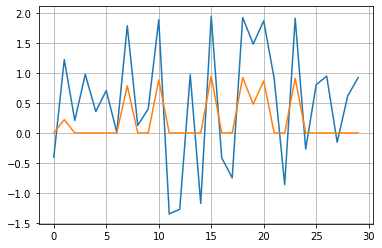

In [17]:
# Note, from here on we will use the same v to be able to make comparisons
v = np.random.normal(size = n)

print(f'Value of v: {v}')
x_l1_plus_nonneg = cp.Variable(n, nonneg = True) 
# Define de the cost function
obj = cp.norm(x_l1_plus_nonneg, 1) + cp.sum_squares(x_l1_plus_nonneg - v)/(2*lamb)

prox_l1_prob = cp.Problem(cp.Minimize(obj))
prox_l1_prob.solve()

print("\nThe optimal value is", prox_l1_prob.value)
print(f"The objective value is: {cp.norm(x_l1_plus_nonneg, 1).value + cp.sum_squares(x_l1_plus_nonneg - v).value/(2*lamb)}")
print(f'The optimal value of x: {x_l1_plus_nonneg.value}')

plt.figure()
plt.plot(v)
plt.plot(x_l1_plus_nonneg.value)
plt.grid()

### <a name = 'l1(nonneg)'></a> 3.2 $L^2$ + Nonneg

In this section we will compute the proximal operator of our regularizer and the nonnegativity constraint combined:
$$prox_f(x)$$
where   
$$f(x) = ||x||_2 +  \delta_{\Re_+^N}$$

Following the definition from [section 1.B](#Proximal), and the derivation of the proximal from the nonnegativity constraint, it follows that:

$$prox_{f}(v) = argmin_{x\in \Re_+^N}(||x||_2 + \frac{1}{2\lambda}||x - v||_2^2))$$

In this term we could add the function $\delta_{\Re_+^N}$, but since we have already defined $x\in \Re_+^N$, its value vanishes. 

Run the next cell to see a toy example, exactly the same as in section [2.2.1](#L1-Norm), but imposing the nonnegativity constraint.

Value of v: [-0.40317695  1.22244507  0.20827498  0.97663904  0.3563664   0.70657317
  0.01050002  1.78587049  0.12691209  0.40198936  1.8831507  -1.34775906
 -1.270485    0.96939671 -1.17312341  1.94362119 -0.41361898 -0.74745481
  1.92294203  1.48051479  1.86755896  0.90604466 -0.86122569  1.91006495
 -0.26800337  0.8024564   0.94725197 -0.15501009  0.61407937  0.92220667]

The optimal value is 8.368707722793665
The objective value is: 21.81111523201451
The optimal value of x: [1.46330344e-08 1.00416357e+00 1.71076484e-01 8.02248616e-01
 2.92729546e-01 5.80405900e-01 8.61709416e-03 1.46698568e+00
 1.04239708e-01 3.30206930e-01 1.54689611e+00 3.17886489e-09
 3.47652958e-09 7.96299482e-01 3.90722484e-09 1.59656939e+00
 1.42181004e-08 7.10149998e-09 1.57958256e+00 1.21615292e+00
 1.53408834e+00 7.44259626e-01 5.93955331e-09 1.56900474e+00
 2.29935942e-08 6.59168179e-01 7.78108923e-01 4.15644238e-08
 5.04427702e-01 7.57535736e-01]


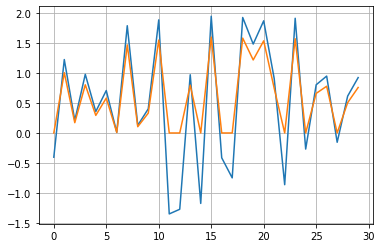

In [18]:
print(f'Value of v: {v}')
x_l2_plus_nonneg = cp.Variable(n, nonneg = True) 
# Define de the cost function
obj = cp.norm(x_l2_plus_nonneg, 2) + cp.sum_squares(x_l2_plus_nonneg - v)/(2*lamb)

prox_l2_prob = cp.Problem(cp.Minimize(obj))
prox_l2_prob.solve()

print("\nThe optimal value is", prox_l2_prob.value)
print(f"The objective value is: {cp.norm(x_l2_plus_nonneg, 1).value + cp.sum_squares(x_l2_plus_nonneg - v).value/(2*lamb)}")
print(f'The optimal value of x: {x_l2_plus_nonneg.value}')

plt.figure()
plt.plot(v)
plt.plot(x_l2_plus_nonneg.value)
plt.grid()

## <a name = '#Prox_reg(prox_nonneg)'></a> 4. $prox_{\Re}(prox_{\delta_{\rm_+}}(x))$

Now that we have the result from the case where $f(x) = \Re +  \delta_{\rm_+^N}$, in this section we will test wether $prox_{\Re}(prox_{\delta_{\rm_+}}(x)) = prox_{\Re +  \delta_{\rm_+^N}}(v)$

### <a name = 'l1_nonneg'></a> 4.1 $L^1$ Norm

$$prox_{L^1 + \delta_{\rm_+}} = prox_{L^1}(prox_{\delta_{\rm_+}}(x))$$

For the purpose, we will recycle code from the previous sections. Most importantly, the vector $v$ should be the same of the previous section.

The optimal value of x: [0.00000000e+00 2.22445070e-01 1.20604506e-27 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.85870494e-01
 2.77561363e-23 2.79015172e-27 8.83150697e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.43621186e-01
 0.00000000e+00 0.00000000e+00 9.22942026e-01 4.80514791e-01
 8.67558960e-01 0.00000000e+00 0.00000000e+00 9.10064953e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


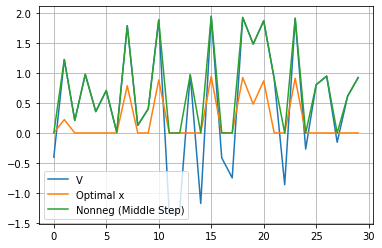

In [19]:
x_l1_o_nonneg = cp.Variable(n, nonneg = True) 

# Solve nonnegativity prox
cost = cp.sum_squares(x_l1_o_nonneg - v)/(2*lamb)
prox_nonneg_prob = cp.Problem(cp.Minimize(cost))
prox_nonneg_prob.solve()
nonneg_vector = np.copy(x_l1_o_nonneg.value)

#Solve L1 Norm
obj = cp.norm(x_l1_o_nonneg, 1) + cp.sum_squares(x_l1_o_nonneg - nonneg_vector)/(2*lamb)
prox_l1_prob = cp.Problem(cp.Minimize(obj))
prox_l1_prob.solve()


print(f'The optimal value of x: {x_l1_o_nonneg.value}')

plt.figure()
plt.plot(v, label = 'V')
plt.plot(x_l1_o_nonneg.value, label = 'Optimal x')
plt.plot(nonneg_vector, label = 'Nonneg (Middle Step)')
plt.legend()
plt.grid()

### <a name = 'l2_nonneg'></a> 4.2 $L^1$ Norm

$$prox_{L^2 + \delta_{\rm_+}} = prox_{L^2}(prox_{\delta_{\rm_+}}(x))$$

For the purpose, we will recycle code from the previous sections. Most importantly, the vector $v$ should be the same of the previous section.

The optimal value of x: [1.46330344e-08 1.00416357e+00 1.71076484e-01 8.02248616e-01
 2.92729546e-01 5.80405900e-01 8.61709416e-03 1.46698568e+00
 1.04239708e-01 3.30206930e-01 1.54689611e+00 3.17886489e-09
 3.47652958e-09 7.96299482e-01 3.90722484e-09 1.59656939e+00
 1.42181004e-08 7.10149998e-09 1.57958256e+00 1.21615292e+00
 1.53408834e+00 7.44259626e-01 5.93955331e-09 1.56900474e+00
 2.29935942e-08 6.59168179e-01 7.78108923e-01 4.15644238e-08
 5.04427702e-01 7.57535736e-01]


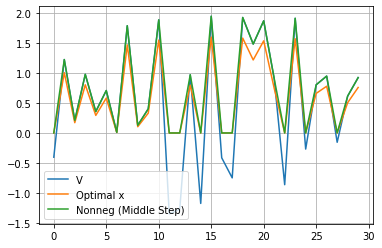

In [20]:
x_l2_o_nonneg = cp.Variable(n, nonneg = True) 

# Solve nonnegativity prox
cost = cp.sum_squares(x_l2_o_nonneg - v)/(2*lamb)
prox_nonneg_prob = cp.Problem(cp.Minimize(cost))
prox_nonneg_prob.solve()
nonneg_vector = np.copy(x_l2_o_nonneg.value)

#Solve L1 Norm
obj = cp.norm(x_l2_o_nonneg, 2) + cp.sum_squares(x_l2_o_nonneg - v)/(2*lamb)
prox_l2_prob = cp.Problem(cp.Minimize(obj))
prox_l2_prob.solve()


print(f'The optimal value of x: {x_l2_o_nonneg.value}')

plt.figure()
plt.plot(v, label = 'V')
plt.plot(x_l2_o_nonneg.value, label = 'Optimal x')
plt.plot(nonneg_vector, label = 'Nonneg (Middle Step)')
plt.legend()
plt.grid()

## <a name = '#Prox_nonneg(prox_reg)'></a> 5. $prox_{\delta_{\rm_+}}(prox_{\Re}(x))$

This section is dedicated to 

### <a name = 'nonneg(l1)'></a> 5.1 $L^1$ Norm

For the purpose, we will recycle code from the previous sections. Most importantly, the vector $v$ should be the same of the previous section.

The optimal value of x: [ 9.25236775e-24  2.22445070e-01  1.20604506e-27 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  7.85870494e-01
  2.77561363e-23  2.79015172e-27  8.83150697e-01 -0.00000000e+00
  1.72563323e-31 -0.00000000e+00  1.59370703e-31  9.43621186e-01
  9.25867038e-24 -0.00000000e+00  9.22942026e-01  4.80514791e-01
  8.67558960e-01 -0.00000000e+00  1.85022626e-23  9.10064953e-01
  1.38785516e-23 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


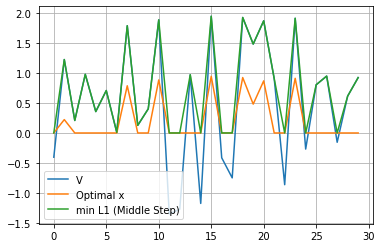

In [21]:
x_nonneg_o_l1 = cp.Variable(n, nonneg = True) 

#Solve L1 Norm
obj = cp.norm(x_nonneg_o_l1, 1) + cp.sum_squares(x_nonneg_o_l1 - v)/(2*lamb)
prox_l1_prob = cp.Problem(cp.Minimize(obj))
prox_l1_prob.solve()
minl1_vector = np.copy(x_nonneg_o_l1.value)

# Solve nonnegativity prox
cost = cp.sum_squares(x_nonneg_o_l1 - minl1_vector)/(2*lamb)
prox_nonneg_prob = cp.Problem(cp.Minimize(cost))
prox_nonneg_prob.solve()

print(f'The optimal value of x: {x_nonneg_o_l1.value}')

plt.figure()
plt.plot(v, label = 'V')
plt.plot(x_nonneg_o_l1.value, label = 'Optimal x')
plt.plot(nonneg_vector, label = 'min L1 (Middle Step)')
plt.legend()
plt.grid()

### <a name = 'nonneg(l2)'></a> 5.1 $L^2$ Norm

For the purpose, we will recycle code from the previous sections. Most importantly, the vector $v$ should be the same of the previous section.

The optimal value of x: [ 9.25236775e-24  2.22445070e-01  1.20604506e-27 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  7.85870494e-01
  2.77561363e-23  2.79015172e-27  8.83150697e-01 -0.00000000e+00
  1.72563323e-31 -0.00000000e+00  1.59370703e-31  9.43621186e-01
  9.25867038e-24 -0.00000000e+00  9.22942026e-01  4.80514791e-01
  8.67558960e-01 -0.00000000e+00  1.85022626e-23  9.10064953e-01
  1.38785516e-23 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


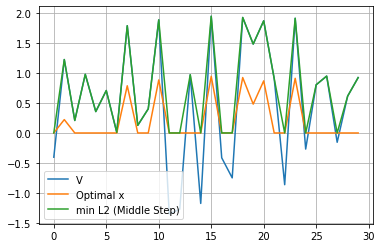

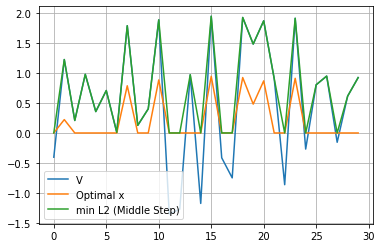

In [22]:
x_nonneg_o_l2 = cp.Variable(n, nonneg = True) 

# Solve L1 Norm
obj = cp.norm(x_nonneg_o_l2, 1) + cp.sum_squares(x_nonneg_o_l2 - v)/(2*lamb)
prox_l2_prob = cp.Problem(cp.Minimize(obj))
prox_l2_prob.solve()
minl2_vector = np.copy(x_nonneg_o_l2.value)

# Solve nonnegativity prox
cost = cp.sum_squares(x_nonneg_o_l2 - minl2_vector)/(2*lamb)
prox_nonneg_prob = cp.Problem(cp.Minimize(cost))
prox_nonneg_prob.solve()

print(f'The optimal value of x: {x_nonneg_o_l2.value}')

plt.figure()
plt.plot(v, label = 'V')
plt.plot(x_nonneg_o_l2.value, label = 'Optimal x')
plt.plot(nonneg_vector, label = 'min L2 (Middle Step)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(v, label = 'V')
plt.plot(x_nonneg_o_l2.value, label = 'Optimal x')
plt.plot(nonneg_vector, label = 'min L2 (Middle Step)')
plt.legend()
plt.grid()

## <a name = '#Comparisons'></a> 6. Comparisons


### <a name = 'coomp_l1'></a> 6.1 $L^1$ Norm

prox_l1(prox_nonneg(v)) is equal to prox(l1 + nonneg)
prox_nonneg(prox_l1(v)) is equal to prox(l1 + nonneg)


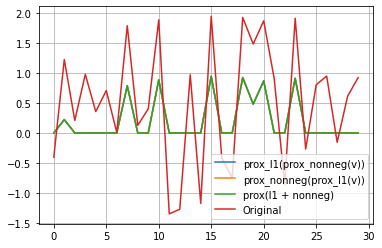

In [23]:
plt.figure()
plt.plot(x_l1_o_nonneg.value, label = 'prox_l1(prox_nonneg(v))')
plt.plot(x_nonneg_o_l1.value, label = 'prox_nonneg(prox_l1(v))')
plt.plot(x_l1_plus_nonneg.value, label = 'prox(l1 + nonneg)')
plt.plot(v, label = 'Original')
plt.legend()
plt.grid()

try:
    np.testing.assert_array_almost_equal(x_l1_plus_nonneg.value, x_l1_o_nonneg.value)
    print(f'prox_l1(prox_nonneg(v)) is equal to prox(l1 + nonneg)')
except:
    print(f'prox_l1(prox_nonneg(v)) is not equal to prox(l1 + nonneg)')

try:
    np.testing.assert_array_almost_equal(x_l1_plus_nonneg.value, x_nonneg_o_l1.value)
    print(f'prox_nonneg(prox_l1(v)) is equal to prox(l1 + nonneg)')
except:
    print(f'prox_nonneg(prox_l1(v)) is not equal to prox(l1 + nonneg)')

### <a name = 'coomp_l2'></a> 6.1 $L^$ Norm

prox_l2(prox_nonneg(v)) is equal to prox(l2 + nonneg)
prox_nonneg(prox_l2(v)) is not equal to prox(l2 + nonneg)


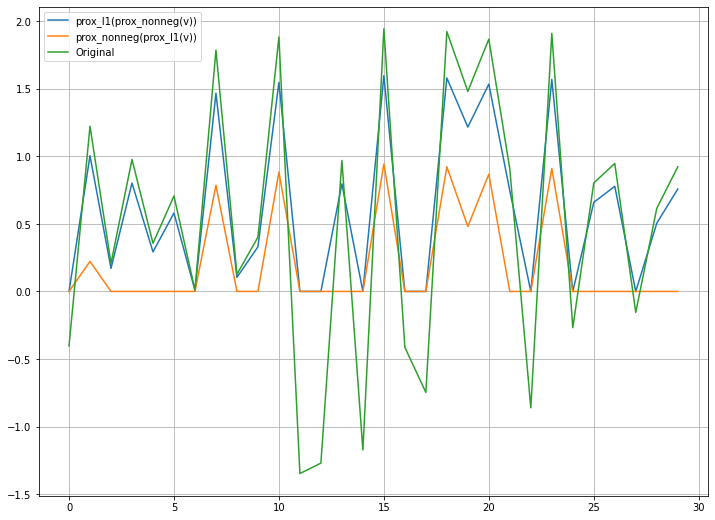

In [25]:
plt.figure(figsize = (12, 9))
plt.plot(x_l2_o_nonneg.value, label = 'prox_l1(prox_nonneg(v))')
plt.plot(x_nonneg_o_l2.value, label = 'prox_nonneg(prox_l1(v))')
# plt.plot(x_l2_plus_nonneg.value, label = 'prox(l1 + nonneg)')
plt.plot(v, label = 'Original')
plt.legend()
plt.grid()

try:
    np.testing.assert_array_almost_equal(x_l2_plus_nonneg.value, x_l2_o_nonneg.value)
    print(f'prox_l2(prox_nonneg(v)) is equal to prox(l2 + nonneg)')
except:
    print(f'prox_l2(prox_nonneg(v)) is not equal to prox(l2 + nonneg)')

try:
    np.testing.assert_array_almost_equal(x_l2_plus_nonneg.value, x_nonneg_o_l2.value)
    print(f'prox_nonneg(prox_l2(v)) is equal to prox(l2 + nonneg)')
except:
    print(f'prox_nonneg(prox_l2(v)) is not equal to prox(l2 + nonneg)')